In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport utils.path
%aimport utils.backtest
%aimport utils.backtest_result_sherlock
%aimport solvers
%aimport solvers.DRconditionalmeanvariance

In [2]:
import tushare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import sys
import factors

In [6]:
exp_num = 50
seed = 42
DRCME_inf_params = {
    'model_name': ['DRCMV'],
    'exp_num':[50], 
    'sample_stock_num':[20], 
    'solver':[solvers.DRconditionalmeanvariance.DR_Winfty_conditional_mean_variance_long_only_opt_cvx_kernel], 
    'start_index':['2012'],
    'end_index':['2014'],
    'reg_params':[0.1], 
    'gamma_quantile':[0.1, 0.25, 0.5], 
    'rho_quantile':[0.05, 0.1, 0.25], 
}
DRCME_2_params = {
    'model_name': ['OTCMV'],
    'exp_num':[50], 
    'sample_stock_num':[20], 
    'solver':[solvers.DRconditionalmeanvariance.DR_W2_conditional_mean_variance_long_only_opt_cvx_kernel_new], 
    'start_index':['2012'],
    'end_index':['2014'],
    'reg_params':[0.1], 
    'epsilon':[0.1,0.2,0.5], 
    'rho_div_rho_min':[1.1,1.2,1.5]
}
equal_weight_params = {
    'model_name': ['EW'],
    'exp_num':[50], 
    'sample_stock_num':[20], 
    'solver':[solvers.simple.equal_weight], 
    'start_index':['2012'],
    'end_index':['2014'],
}
DR_params = {
    'model_name': ['DRMV'],
    'exp_num':[50], 
    'sample_stock_num':[20], 
    'solver':[solvers.DRmeanvariance.DR_mean_variance_long_only_opt_mosek_kernel_p2], 
    'reg_params':[0.1],
    'delta': [0.1,0.2,0.5],
    'p': [2.0],
    'start_index':['2012'],
    'end_index':['2014'],
}
mean_variance_params = {
    'model_name': ['MV'],
    'exp_num':[50], 
    'sample_stock_num':[20], 
    'solver':[solvers.meanvariance.mean_variance_long_only_opt_mosek_kernel], 
    'solver_name_prefix': ['vanilla_'],
    'reg_params':[0.1], 
    'start_index':['2012'],
    'end_index':['2014'],
}
conditional_mean_variance_params = {
    'model_name': ['CMV'],
    'exp_num':[50], 
    'sample_stock_num':[20], 
    'solver':[solvers.meanvariance.mean_variance_long_only_opt_mosek_kernel], 
    'solver_name_prefix': ['fama_french_'],
    'reg_params':[0.1], 
    'start_index':['2012'],
    'end_index':['2014'],
}

In [7]:
plt.rc('axes', facecolor='#dedede', edgecolor='none',
       axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')
plt.rc('patch', edgecolor='#dedede')
plt.rcParams['figure.figsize'] = 8,6
plt.rcParams['font.size'] = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [8]:
from utils.backtest_result_sherlock import read_single_solver_backtest_cross_validation_result
CV_params_dict_list = [equal_weight_params,
                     mean_variance_params,
                     DR_params,
                     conditional_mean_variance_params,
                     DRCME_inf_params,
                     DRCME_2_params]
exp_num = 256; seed = 0;
PnL_table_list = [read_single_solver_backtest_cross_validation_result(exp_num, seed, CV_params_dict)
                      for CV_params_dict in CV_params_dict_list]
legend_str_list = [CV_params_dict['model_name'][0] for CV_params_dict in CV_params_dict_list]

In [9]:
SR_table = pd.DataFrame({legend_str_list[i]:np.sqrt(252) * PnL_table_list[i].mean() 
                         / PnL_table_list[i].std() for i in range(6)})

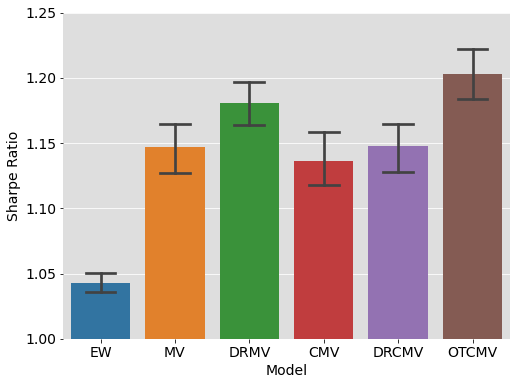

In [10]:
import seaborn as sns
sns.barplot(data=SR_table, ci = 68, capsize = 0.4)
plt.ylim([1,1.25])
plt.ylabel('Sharpe Ratio')
plt.xlabel('Model')
plt.savefig('figures/Chinese_sharpe_bar_plot.pdf')

In [11]:
from scipy import stats
for i in range(5):
    print(stats.ttest_ind(SR_table.iloc[:,i],SR_table.iloc[:,-1], equal_var = False))

Ttest_indResult(statistic=-7.470471920909098, pvalue=7.711935389932543e-13)
Ttest_indResult(statistic=-2.014156173206445, pvalue=0.04451978201452556)
Ttest_indResult(statistic=-0.8476845686648742, pvalue=0.3970222523222239)
Ttest_indResult(statistic=-2.317461012808642, pvalue=0.02087363682917998)
Ttest_indResult(statistic=-2.009899504066385, pvalue=0.04497074797711953)


In [12]:
quantile_table = pd.DataFrame({legend_str_list[i]:PnL_table_list[i].quantile(0.05) for i in range(6)})

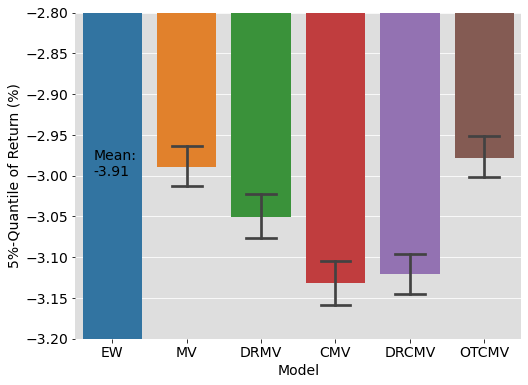

In [14]:
sns.barplot(data=quantile_table, ci = 68, capsize = 0.4)
plt.ylim([-3.2,-2.8])
plt.ylabel('5%-Quantile of Return (%)')
plt.xlabel('Model')
plt.text(-0.25,-3,'Mean:\n{:.2f}'.format(quantile_table.iloc[:,0].mean()))
plt.savefig('figures/Chinese_return_quantile_bar_plot.pdf')